In [1]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
pip install wandb

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Download latest version
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")

print("Path to dataset files:", path)

files =os.listdir(path)
print("Files in dataset folder:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)
print("Path to CSV file:", csv_path)

100%|██████████| 21.5k/21.5k [00:00<00:00, 10.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1
Files in dataset folder: ['WineQT.csv']
Path to CSV file: /root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv


In [5]:
my_dataframe = pd.read_csv(csv_path)
my_dataframe.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,6
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,8
9,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,10


In [6]:
my_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


#Data Preprocessing

In [7]:
my_dataframe = my_dataframe.drop(columns=['Id'])
my_dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
my_dataframe.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
# Splitting features and target
y = my_dataframe["quality"]  # Target variable
X = my_dataframe.drop(columns=["quality"])

In [10]:
desired_df = my_dataframe[['volatile acidity','citric acid','sulphates','alcohol','quality']]
desired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volatile acidity  1143 non-null   float64
 1   citric acid       1143 non-null   float64
 2   sulphates         1143 non-null   float64
 3   alcohol           1143 non-null   float64
 4   quality           1143 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 44.8 KB


In [11]:
feature_columns = ['volatile acidity','citric acid','sulphates','alcohol']
label_column = ['quality']

# Extract features and label
features = desired_df[feature_columns].values
labels = desired_df[label_column].values

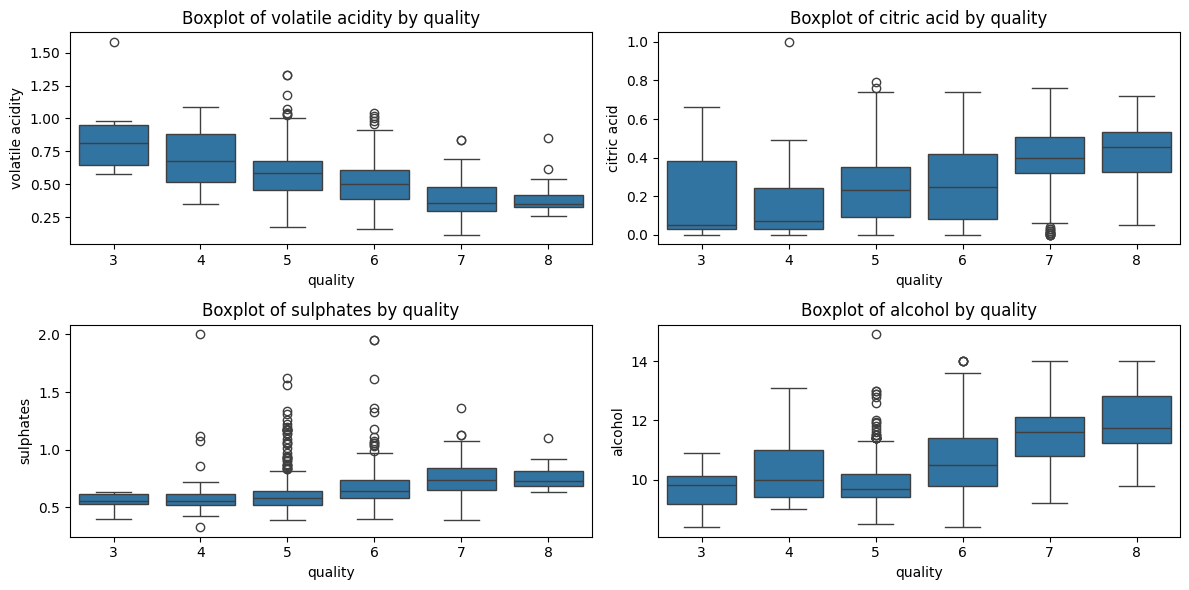

In [12]:
# Visualize Quality across 'volatile acidity','citric acid','sulphates'and 'alcohol'
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.boxplot(x='quality', y='volatile acidity', data=my_dataframe)
plt.title('Boxplot of volatile acidity by quality')

plt.subplot(2, 2, 2)
sns.boxplot(x='quality', y='citric acid', data=my_dataframe)
plt.title('Boxplot of citric acid by quality')

plt.subplot(2, 2, 3)
sns.boxplot(x='quality', y='sulphates', data=my_dataframe)
plt.title('Boxplot of sulphates by quality')

plt.subplot(2, 2, 4)
sns.boxplot(x='quality', y='alcohol', data=my_dataframe)
plt.title('Boxplot of alcohol by quality')

plt.tight_layout()
plt.show()

In [13]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

# Remove outliers for each feature
for feature in ['volatile acidity', 'citric acid', 'sulphates', 'alcohol']:
    desired_df = remove_outliers(desired_df, feature)
    desired_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 0 to 1142
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volatile acidity  1129 non-null   float64
 1   citric acid       1129 non-null   float64
 2   sulphates         1129 non-null   float64
 3   alcohol           1129 non-null   float64
 4   quality           1129 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 52.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 1128 entries, 0 to 1142
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volatile acidity  1128 non-null   float64
 1   citric acid       1128 non-null   float64
 2   sulphates         1128 non-null   float64
 3   alcohol           1128 non-null   float64
 4   quality           1128 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 52.9 KB
<class 'pandas.core.frame.DataFrame'>


In [14]:
scaler = MinMaxScaler()
#or
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(my_dataframe[feature_columns])

normalized_data = scaler.transform(my_dataframe[feature_columns])
df_normalized = pd.DataFrame(normalized_data, columns=feature_columns)
df_normalized.head()

,volatile acidity,citric acid,sulphates,alcohol
0,-0.205479,-1.00,-0.724551,-0.692308
1,0.041096,-1.00,-0.580838,-0.569231
2,-0.123288,-0.92,-0.616766,-0.569231
3,-0.780822,0.12,-0.700599,-0.569231
4,-0.205479,-1.00,-0.724551,-0.692308


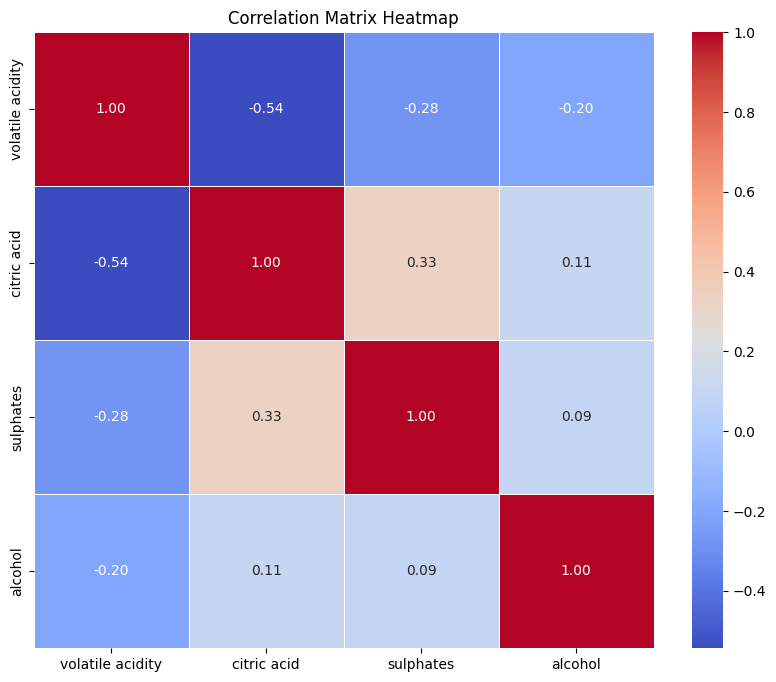

In [15]:
# Calculate correlation matrix
corr_matrix = df_normalized.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [16]:
# Split into train and temp (80% train, 20% temp)
train_data, test_data = train_test_split(df_normalized, test_size=0.2, random_state=42)

# Split temp into eval and test (50% of temp each, i.e., 10% each of original data)
eval_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Print the sizes of each subset
print("Train Data:")
print(train_data)
print("\nEval Data:") # 50% of the test subset
print(eval_data)
print("\nTest Data:") # 50% of the test subset
print(test_data)

Train Data:
      volatile acidity  citric acid  sulphates   alcohol
12           -0.780822         0.12  -0.497006 -0.353846
758          -0.726027         0.12  -0.520958 -0.076923
636          -0.739726        -0.28  -0.568862  0.046154
1109          0.041096        -0.92  -0.724551 -0.538462
743          -0.589041        -0.50  -0.712575 -0.784615
...                ...          ...        ...       ...
1044          0.260274        -0.84  -0.712575 -0.200000
1095         -0.630137        -0.40  -0.664671 -0.815385
1130         -0.684932        -0.34  -0.676647  0.076923
860          -0.383562        -0.38  -0.568862 -0.661538
1126         -0.452055        -0.20  -0.628743  0.046154

[914 rows x 4 columns]

Eval Data:
      volatile acidity  citric acid  sulphates   alcohol
86           -0.479452        -0.66  -0.820359 -0.661538
1136         -0.410959        -0.70  -0.413174 -0.015385
1097         -0.410959        -0.74  -0.688623 -0.600000
558          -0.575342        -0.40  -0.

In [17]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Assuming 'quality' is a categorical variable
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets
training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, y_val_tensor)

#Model Initialization

In [19]:
# Multi-class Classification (Softmax)
multi_class_model = nn.Sequential(
    nn.Linear(4, 64),  # Input size 4 (for 4 features), second layer 64 units
    nn.ReLU(),
    nn.Dropout(0.2),  # Dropout layer with a dropout probability of 0.2
    nn.Linear(64, 32),  # Hidden layer with 32 units
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 6),  # Output size 6 for 6 quality classes (3-8)
    nn.Softmax(dim=1)  # Apply softmax activation to the output
)

In [20]:
class MultiClassClassification(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, second_layer_neurons=64, num_classes=6, dropout_rate=0.2):
        super(MultiClassClassification, self).__init__()
        self.linear1 = nn.Linear(input_size, second_layer_neurons)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(second_layer_neurons, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
def build_optimizer(network, optimizer_name, learning_rate):
    if optimizer_name == "adam":
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = optim.AdamW(network.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}") # Handle unsupported optimizers

    return optimizer  # Return the optimizer object

In [23]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()  # Zero the parameter gradients
        output = model(data)  # Forward pass
        # Assuming 'target' has labels 3 to 8, and needs to be shifted to 0 to 5
        target_shifted = target - 3
        # Squeeze target_shifted to make it 1D
        target_shifted = target_shifted.squeeze(1)
        loss = loss_fn(output, target_shifted)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader) # Return average epoch loss

In [24]:
# Define the model builder function
def build_model(hp):
  input_size = hp.input_size
  hidden_size = hp.hidden_size
  second_layer_neurons = hp.second_layer_neurons
  num_classes = hp.num_classes
  dropout_rate = hp.dropout_rate
  model = MultiClassClassification(input_size, hidden_size, second_layer_neurons, num_classes, dropout_rate)
  return model

#Hyperparameter Tuning

In [25]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'adamw']
        },
    'input_size': {
        'values': [4]
        },
    'second_layer_neurons': {
        'values': [4, 8, 16, 32, 64]
        },
    'hidden_size': {
        'values': [4, 8, 16, 32, 64]
        },
    'num_classes': {
        'values': [6]
        },
    'dropout_rate': {
        'values': [0.2, 0.3, 0.4, 0.5]
        }
    }
sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 1000}
    })
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.001
        'distribution': 'uniform',
        'min': 0,
        'max': 0.0001
      },
    'batch_size': {
        # integers between 4 and 64
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 6,
        'min': 4,
        'max': 64,
      }
    })
# Start the sweep
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 5fv2demg
Sweep URL: https://wandb.ai/sibusisongcana-cortex-hub/pytorch-sweeps-demo/sweeps/5fv2demg


In [26]:
def train():
    with wandb.init() as run:
        config = wandb.config

        # Build the model
        model = build_model(config)

        # Create DataLoaders
        training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        training_data_loader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True)

        # Build the optimizer
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

        # Training loop (call train_epoch)
        for epoch in range(config.epochs):
            loss = train_epoch(model, training_data_loader, optimizer, criterion)
            wandb.log({"epoch": epoch, "loss": loss})

# Start the sweep
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: nh7etj71
Sweep URL: https://wandb.ai/sibusisongcana-cortex-hub/pytorch-sweeps-demo/sweeps/nh7etj71


In [27]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: q5wdeqyx with config:
wandb: 	batch_size: 12
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 1000
wandb: 	hidden_size: 16
wandb: 	input_size: 4
wandb: 	learning_rate: 4.8314164707442365e-05
wandb: 	num_classes: 6
wandb: 	optimizer: adamw
wandb: 	second_layer_neurons: 8
wandb: Currently logged in as: sibusisongcana (sibusisongcana-cortex-hub) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
loss,█▇▅▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
loss,1.55936


wandb: Agent Starting Run: bllj58f3 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 1000
wandb: 	hidden_size: 64
wandb: 	input_size: 4
wandb: 	learning_rate: 8.232240220657664e-05
wandb: 	num_classes: 6
wandb: 	optimizer: adamw
wandb: 	second_layer_neurons: 64


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
loss,██▇▇▆▆▆▆▆▅▄▄▄▄▃▃▂▃▃▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch,999
loss,1.45997


wandb: Agent Starting Run: bteztcjv with config:
wandb: 	batch_size: 24
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 1000
wandb: 	hidden_size: 32
wandb: 	input_size: 4
wandb: 	learning_rate: 1.7656679524162578e-05
wandb: 	num_classes: 6
wandb: 	optimizer: adamw
wandb: 	second_layer_neurons: 16


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇██
loss,██▇▆▆▃▃▃▃▂▃▂▂▂▂▂▁▁▂▂▁▂▂▂▂▂▂▁▂▂▁▂▁▂▂▂▁▂▁▁
epoch,999
loss,1.57248


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f77iy1gl with config:
wandb: 	batch_size: 6
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 1000
wandb: 	hidden_size: 32
wandb: 	input_size: 4
wandb: 	learning_rate: 8.117150883355588e-05
wandb: 	num_classes: 6
wandb: 	optimizer: adam
wandb: 	second_layer_neurons: 8


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
loss,████▇▇▇▇▆▆▅▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁
epoch,999
loss,1.46851


wandb: Agent Starting Run: mgsviq44 with config:
wandb: 	batch_size: 36
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 1000
wandb: 	hidden_size: 4
wandb: 	input_size: 4
wandb: 	learning_rate: 1.871899921447291e-05
wandb: 	num_classes: 6
wandb: 	optimizer: adamw
wandb: 	second_layer_neurons: 4


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
loss,██▇▇▆▆▅▆▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,999
loss,1.59876


In [28]:
#Hyperparameters

learning_rate = 8.232240220657664e-05
batch_size = 6
num_epochs = 1000
dropout_rate = 0.5

In [29]:
# Create DataLoaders
training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = TensorDataset(X_val_tensor, y_val_tensor)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [30]:
input_size = X_train.shape[1]
MultiClassClassification_module = MultiClassClassification(input_size=input_size, dropout_rate=0.5)

In [31]:
optimizer = torch.optim.AdamW(MultiClassClassification_module.parameters(), lr=learning_rate)

In [32]:
wandb.login()

True

In [33]:
# Training Loop
train_losses = []
eval_losses = []
train_accuracy = []
val_accuracy = []

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Wine Quality Project",

    # track hyperparameters and run metadata
    config={
             "learning_rate": learning_rate,
             "architecture": "MultiClassClassification",
             "dataset": "Wine Quality Dataset",
             "epochs": num_epochs,
             "batch_size": batch_size,
             "dropout_rate": dropout_rate
    }
)
for epoch in range(num_epochs):
    # Training
    MultiClassClassification_module.train()  # Set the model to training mode
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(training_data_loader):
        optimizer.zero_grad()
        output = MultiClassClassification_module(data)

        # Assuming 'target' has labels 3 to 8, and needs to be shifted to 0 to 5
        target_shifted = target - 3

        # Squeeze target_shifted to make it 1D
        target_shifted = target_shifted.squeeze(1) #This line is added to fix the error. It removes the extra dimension

        loss = criterion(output, target_shifted)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)

        # Shift predicted labels back to the original range for accuracy calculation
        predicted_shifted = predicted + 3
        correct_train += (predicted_shifted == target.squeeze(1)).sum().item()

    train_losses.append(epoch_train_loss / len(training_data_loader))
    train_accuracy.append(100 * correct_train / total_train)

    # Validation
    MultiClassClassification_module.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to calculate gradients during validation
        for data, target in validation_data_loader:
            output = MultiClassClassification_module(data)

            # Assuming 'target' has labels 3 to 8, and needs to be shifted to 0 to 5
            target_shifted = target - 3

            # Squeeze target_shifted to make it 1D for validation as well
            target_shifted = target_shifted.squeeze(1) #This line is added to fix the error. It removes the extra dimension

            loss = criterion(output, target_shifted)

            epoch_val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)

            # Shift predicted labels back to the original range for accuracy calculation
            predicted_shifted = predicted + 3
            correct_val += (predicted_shifted == target.squeeze(1)).sum().item()

    eval_losses.append(epoch_val_loss / len(validation_data_loader))
    val_accuracy.append(100 * correct_val / total_val)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_losses[-1],
        "val_loss": eval_losses[-1],
        "train_accuracy": train_accuracy[-1],
        "val_accuracy": val_accuracy[-1]
   })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {eval_losses[-1]:.4f}, '
         f'Train Acc: {train_accuracy[-1]:.2f}%, Val Acc: {val_accuracy[-1]:.2f}%')

wandb.finish()

Epoch [1/1000], Train Loss: 1.7223, Val Loss: 1.6907, Train Acc: 35.45%, Val Acc: 42.36%
Epoch [2/1000], Train Loss: 1.6826, Val Loss: 1.6510, Train Acc: 38.95%, Val Acc: 41.92%
Epoch [3/1000], Train Loss: 1.6511, Val Loss: 1.6167, Train Acc: 39.72%, Val Acc: 44.54%
Epoch [4/1000], Train Loss: 1.6265, Val Loss: 1.5949, Train Acc: 42.23%, Val Acc: 43.23%
Epoch [5/1000], Train Loss: 1.6167, Val Loss: 1.5840, Train Acc: 39.50%, Val Acc: 43.67%
Epoch [6/1000], Train Loss: 1.6062, Val Loss: 1.5759, Train Acc: 39.82%, Val Acc: 43.23%
Epoch [7/1000], Train Loss: 1.5984, Val Loss: 1.5721, Train Acc: 40.26%, Val Acc: 43.23%
Epoch [8/1000], Train Loss: 1.5987, Val Loss: 1.5693, Train Acc: 40.81%, Val Acc: 44.10%
Epoch [9/1000], Train Loss: 1.5954, Val Loss: 1.5680, Train Acc: 40.15%, Val Acc: 44.54%
Epoch [10/1000], Train Loss: 1.5948, Val Loss: 1.5657, Train Acc: 40.59%, Val Acc: 46.29%
Epoch [11/1000], Train Loss: 1.5933, Val Loss: 1.5644, Train Acc: 41.14%, Val Acc: 46.29%
Epoch [12/1000], Tr

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
train_accuracy,▁▁▃▃▃▄▄▃▄▃▄▄▅▅▅▆▆▇▆▆███▇▇███▇▇▇▇▇█▇▇██▇█
train_loss,███████▇▇█▇▇▆▆▆▅▅▅▄▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁
val_accuracy,▁▃▅▃▃▃▄▄▆▅▆▆▆▆▆▇▇▆█▇█████████▇██████▇███
val_loss,████▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,1000
train_accuracy,56.56455
train_loss,1.47196
val_accuracy,60.69869
val_loss,1.44883


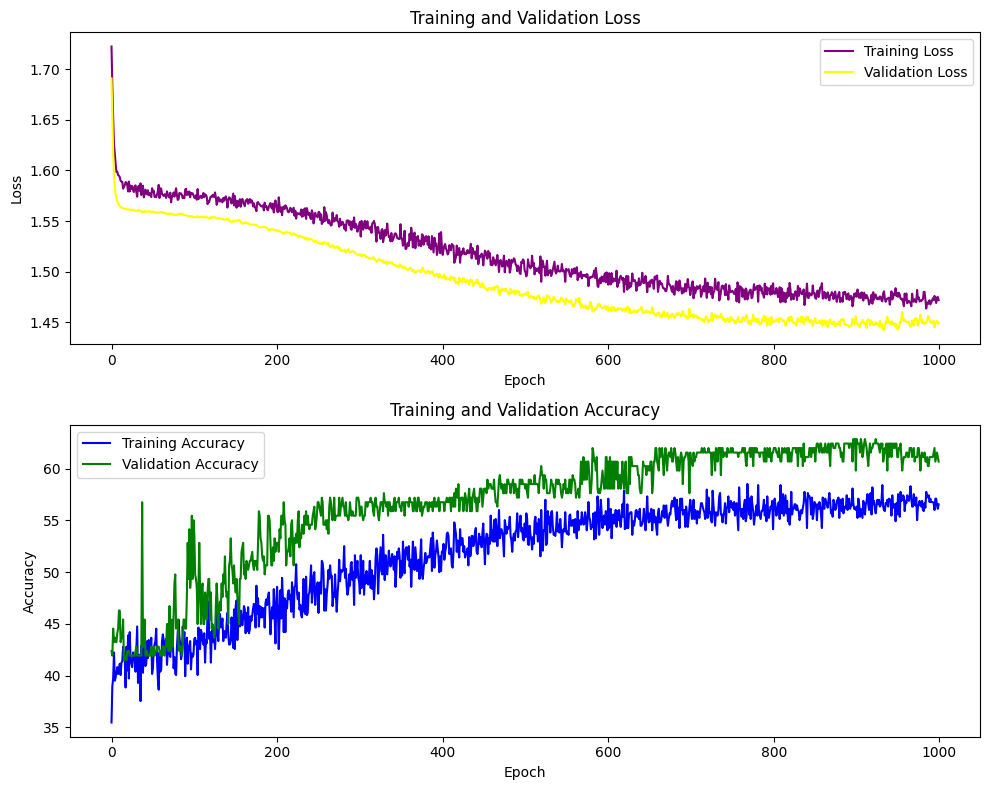

In [34]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot Loss
axs[0].plot(train_losses, label='Training Loss', color='purple')
axs[0].plot(eval_losses, label='Validation Loss', color='Yellow')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(train_accuracy, label='Training Accuracy', color='blue')
axs[1].plot(val_accuracy, label='Validation Accuracy', color='green')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### References
1. Dataset: **Wine Quality Dataset** ([Kaggle Link](https://www.kaggle.com/your-dataset))    
2. WANDB Tracking: [WANDB Documentation](https://docs.wandb.ai/)
3. WANDB Sweeps: [WANDB Notebook](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb#scrollTo=VJncqPru7Rge)
4. Gemini AI tool: [Gemini](https://gemini.google.com/)
5. Luthando Maqondo: AI & Machine Learning @CORTEXHUB